In [32]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [33]:
# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Define the folder containing all CSV files
data_folder = "./data/"  # Change this to your actual path

In [34]:
# Read and merge all CSV files
all_files = glob.glob(os.path.join(data_folder, "*.csv"))
df_list = []
for file in all_files:
    try:
        temp_df = pd.read_csv(file, encoding='latin1', low_memory=False)
        if temp_df.shape[0] > 0:
            temp_df.columns = temp_df.columns.str.strip().str.lower()
            label_col = [col for col in temp_df.columns if 'label' in col.lower()]
            if label_col:
                temp_df.rename(columns={label_col[0]: 'label'}, inplace=True)
            df_list.append(temp_df)
            print(f"Loaded: {file} ({temp_df.shape[0]} rows)")
        else:
            print(f"Skipping empty file: {file}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if not df_list:
    raise ValueError("No valid data found in CSV files.")

df = pd.concat(df_list, ignore_index=True)

Loaded: ./data\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (225745 rows)
Loaded: ./data\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (286467 rows)
Loaded: ./data\Friday-WorkingHours-Morning.pcap_ISCX.csv (191033 rows)
Loaded: ./data\Monday-WorkingHours.pcap_ISCX.csv (529918 rows)
Loaded: ./data\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (288602 rows)
Loaded: ./data\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (170366 rows)
Loaded: ./data\Tuesday-WorkingHours.pcap_ISCX.csv (445909 rows)
Loaded: ./data\Wednesday-workingHours.pcap_ISCX.csv (692703 rows)


In [35]:
# Enable GPU Acceleration
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("✅ GPU is enabled for TensorFlow.")
else:
    print("⚠️ No GPU found. Running on CPU.")

⚠️ No GPU found. Running on CPU.


In [36]:
# Exploratory Data Analysis (EDA)
# Display first few rows
print(df.head())

# Summary statistics
print(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing Values per Column:\n{missing_values[missing_values > 0]}")


   destination port  flow duration  total fwd packets  total backward packets  \
0             54865              3                  2                       0   
1             55054            109                  1                       1   
2             55055             52                  1                       1   
3             46236             34                  1                       1   
4             54863              3                  2                       0   

   total length of fwd packets  total length of bwd packets  \
0                           12                            0   
1                            6                            6   
2                            6                            6   
3                            6                            6   
4                           12                            0   

   fwd packet length max  fwd packet length min  fwd packet length mean  \
0                      6                      6            

       destination port  flow duration  total fwd packets  \
count       2830743.000    2830743.000        2830743.000   
mean           8071.483   14785663.930              9.361   
std           18283.632   33653744.086            749.673   
min               0.000        -13.000              1.000   
25%              53.000        155.000              2.000   
50%              80.000      31316.000              2.000   
75%             443.000    3204828.500              5.000   
max           65535.000  119999998.000         219759.000   

       total backward packets  total length of fwd packets  \
count             2830743.000                  2830743.000   
mean                   10.394                      549.302   
std                   997.388                     9993.589   
min                     0.000                        0.000   
25%                     1.000                       12.000   
50%                     2.000                       62.000   
75%             

Missing Values per Column:
flow bytes/s    1358
dtype: int64


In [37]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values


In [38]:
df.dropna(axis=1, how='all', inplace=True)
print("Columns dropped with all missing values.")

Columns dropped with all missing values.


In [39]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
print("Missing values in numeric columns filled with mean.")
df.drop_duplicates(inplace=True)
print("Duplicates removed.")

Missing values in numeric columns filled with mean.
Duplicates removed.


In [40]:
# Handle categorical features
non_numeric_columns = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {non_numeric_columns}")
if 'label' in non_numeric_columns:
    df['label'] = df['label'].astype(str)
    df['label'] = pd.factorize(df['label'])[0]
    non_numeric_columns.remove('label')
if non_numeric_columns:
    df = pd.get_dummies(df, columns=non_numeric_columns)
    print("Categorical features one-hot encoded.")

Categorical columns: ['label']


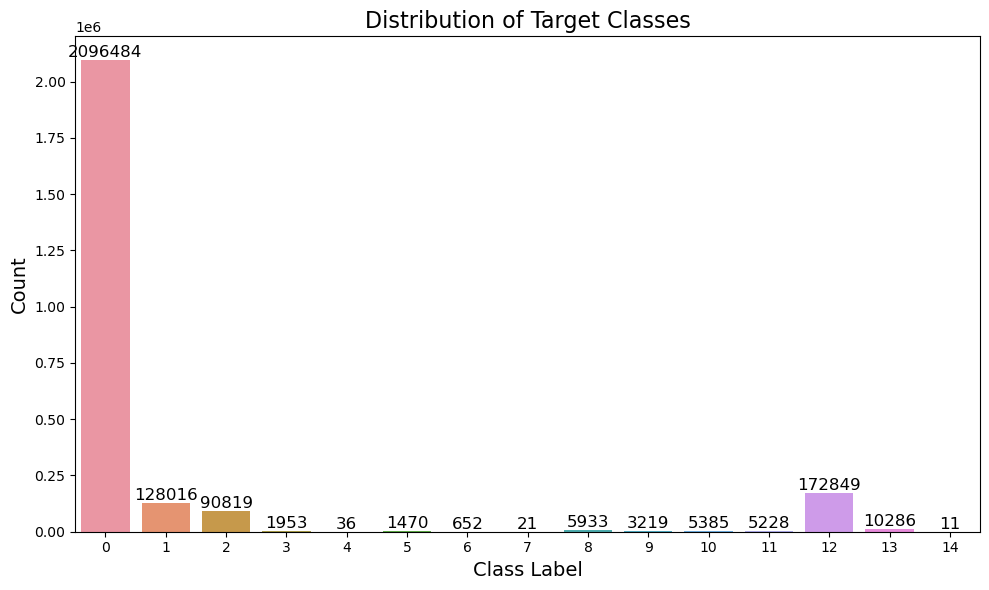

In [41]:
# 1. Distribution of the target variable (class distribution)
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=df)
plt.title('Distribution of Target Classes', fontsize=16)
plt.xlabel('Class Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()


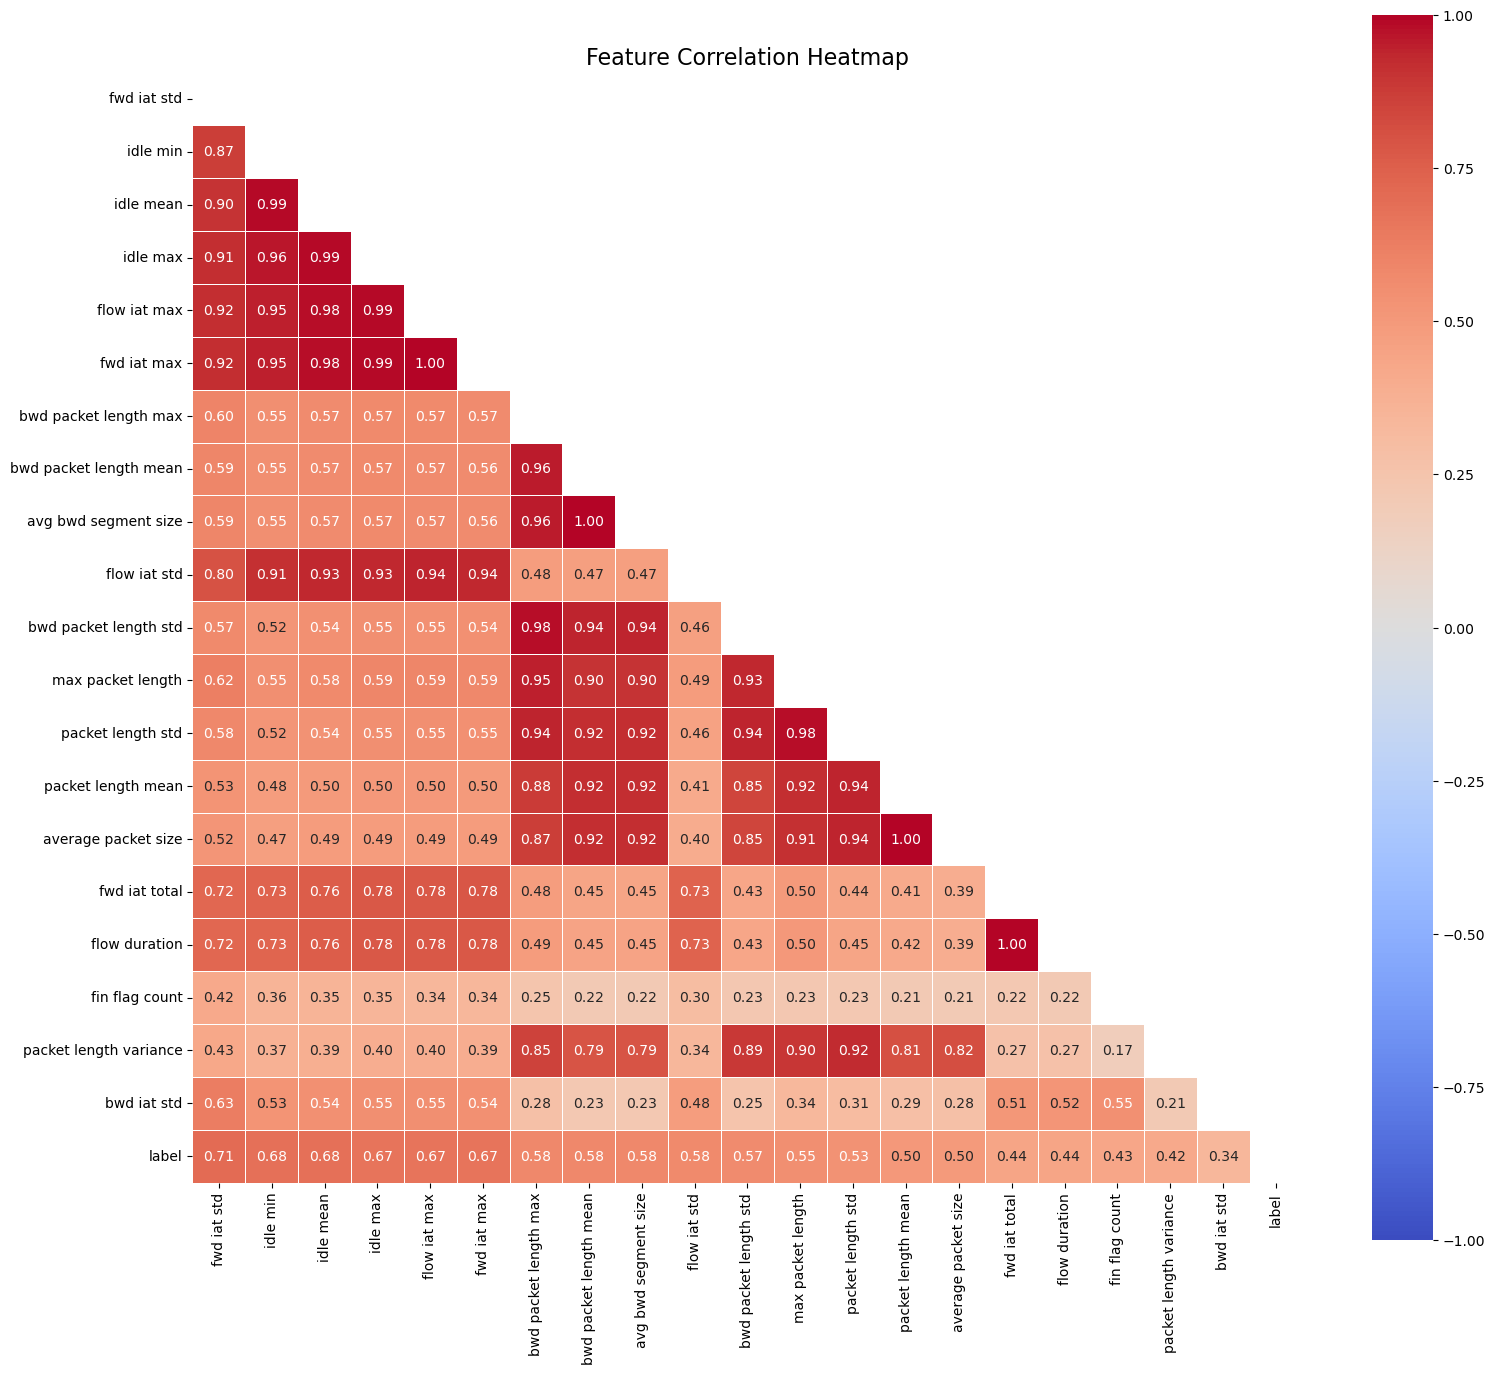

In [42]:
# 2. Correlation heatmap of numeric features
plt.figure(figsize=(16, 14))
# Select only numeric columns and exclude the target
numeric_df = df.select_dtypes(include=[np.number])
if 'label' in numeric_df.columns:
    correlation_cols = numeric_df.drop(columns=['label']).columns
    # Select top 20 features by correlation with target (if too many features)
    if len(correlation_cols) > 20:
        correlations = numeric_df[correlation_cols].corrwith(numeric_df['label'])
        top_features = correlations.abs().nlargest(20).index
        correlation_matrix = numeric_df[list(top_features) + ['label']].corr()
    else:
        correlation_matrix = numeric_df.corr()
else:
    # If no label column, just show all correlations
    correlation_cols = numeric_df.columns
    if len(correlation_cols) > 20:
        correlation_matrix = numeric_df.iloc[:, :20].corr()
    else:
        correlation_matrix = numeric_df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, 
            annot=True, fmt='.2f', linewidths=0.5, square=True)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()


In [43]:
# Feature Selection - Drop irrelevant columns
irrelevant_columns = ['timestamp', 'flow_id'] if 'timestamp' in df.columns and 'flow_id' in df.columns else []
df.drop(columns=irrelevant_columns, inplace=True, errors='ignore')
print(f"Dropped irrelevant columns: {irrelevant_columns}")

Dropped irrelevant columns: []


In [44]:
# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['label']))
print("Features scaled.")

Features scaled.


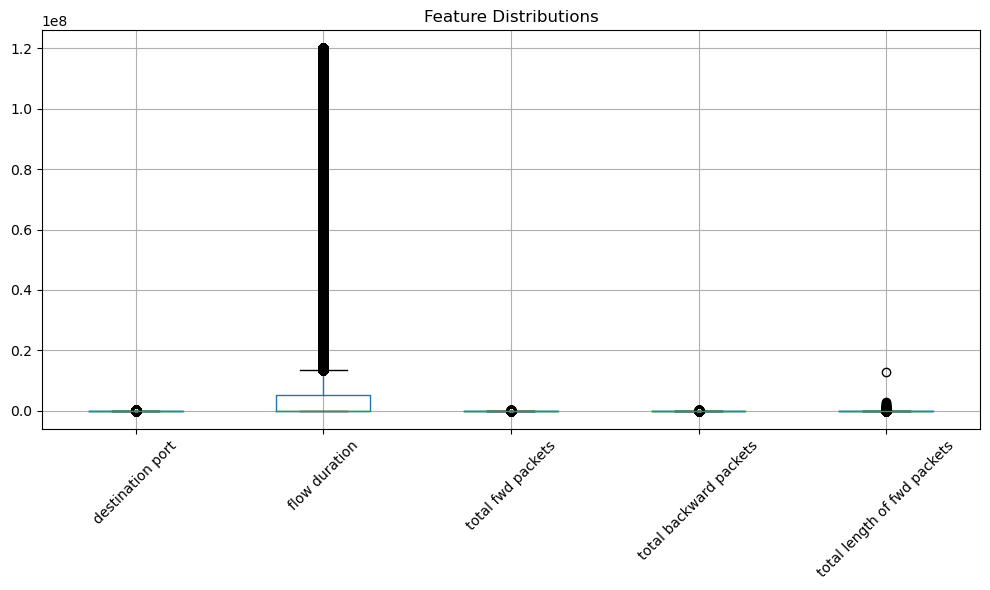

In [46]:
# 3. Simple boxplot for top 5 numeric features
plt.figure(figsize=(10, 6))
numeric_cols = df.select_dtypes(include=[np.number]).columns
# Take 5 columns only, excluding label if it exists
if 'label' in numeric_cols:
    numeric_cols = numeric_cols.drop('label')
cols_to_plot = numeric_cols[:5]  # Just take first 5 columns
df[cols_to_plot].boxplot()
plt.title('Feature Distributions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\M. Hamza Khalid\AppData\Local\Temp\ipykernel_17264\739255934.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


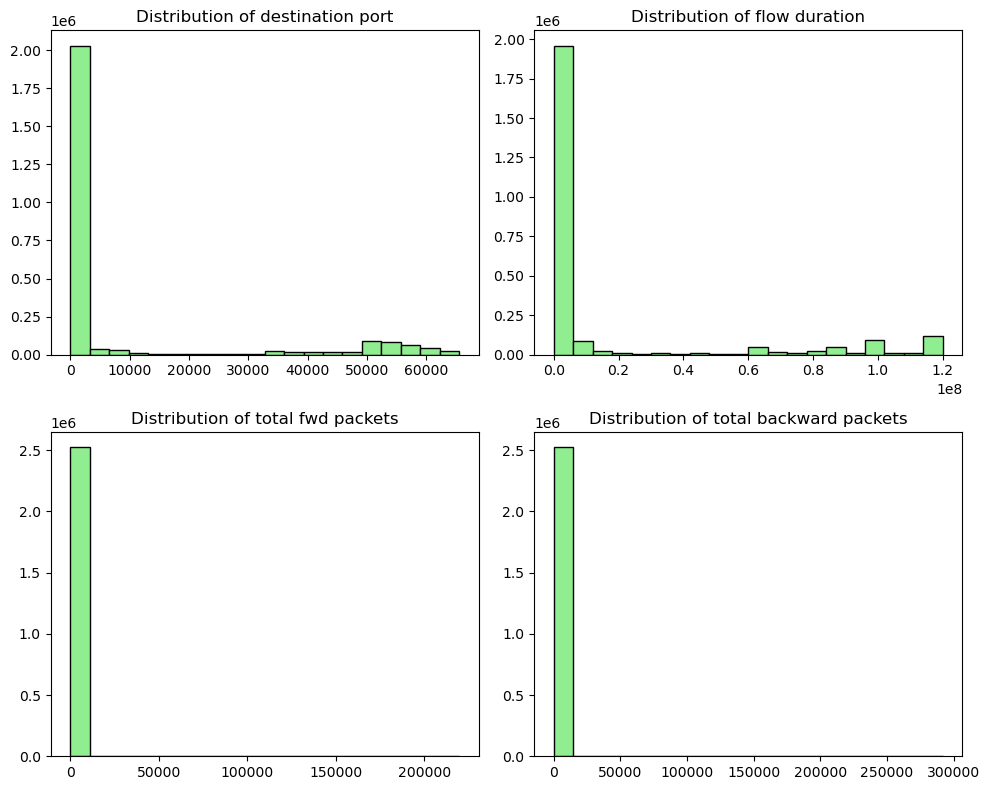

In [47]:
# 4. Histogram of top 4 numeric features
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
if 'label' in numeric_cols:
    numeric_cols = numeric_cols.drop('label')
cols_to_plot = numeric_cols[:4]  # Take first 4 columns

for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 2, i+1)
    plt.hist(df[col], bins=20, color='lightgreen', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

In [12]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, df['label'], test_size=0.2, random_state=42, stratify=df['label'])
print("Train-test split completed.")

Train-test split completed.


In [13]:
# Model 1: Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf, zero_division=1))

# Fix ROC-AUC Error for Multi-Class Classification
if len(np.unique(y_test)) > 2:
    roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test), multi_class='ovr')
else:
    roc_auc = roc_auc_score(y_test, y_pred_rf)
print(f"AUC-ROC: {roc_auc:.3f}")

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    419297
           1       1.00      1.00      1.00     25603
           2       0.99      1.00      0.99     18164
           3       0.88      0.68      0.76       391
           4       1.00      0.57      0.73         7
           5       0.71      0.92      0.80       294
           6       0.49      0.15      0.23       130
           7       1.00      0.00      0.00         4
           8       1.00      1.00      1.00      1187
           9       1.00      1.00      1.00       644
          10       1.00      0.99      1.00      1077
          11       0.99      0.99      0.99      1046
          12       1.00      1.00      1.00     34570
          13       1.00      0.99      0.99      2057
          14       1.00      1.00      1.00         2

    accuracy                           1.00    504473
   macro avg       0.94      0.82      0.83    504473

In [14]:
# Model 2: Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42, n_jobs=-1)
iso_forest.fit(X_train)
y_pred_if = iso_forest.predict(X_test)
y_pred_if = np.where(y_pred_if == -1, 1, 0)
print("Isolation Forest Performance:")
print(classification_report(y_test, y_pred_if, zero_division=1))

Isolation Forest Performance:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90    419297
           1       0.11      0.21      0.14     25603
           2       1.00      0.00      0.00     18164
           3       1.00      0.00      0.00       391
           4       1.00      0.00      0.00         7
           5       1.00      0.00      0.00       294
           6       1.00      0.00      0.00       130
           7       1.00      0.00      0.00         4
           8       1.00      0.00      0.00      1187
           9       1.00      0.00      0.00       644
          10       1.00      0.00      0.00      1077
          11       1.00      0.00      0.00      1046
          12       1.00      0.00      0.00     34570
          13       1.00      0.00      0.00      2057
          14       1.00      0.00      0.00         2

    accuracy                           0.79    504473
   macro avg       0.93      0.08      0.07    504

In [15]:
# Model 3: Autoencoder (Using GPU)
input_dim = X_train.shape[1]
autoencoder = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

# Use GPU for training
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test), verbose=1)

X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
threshold = np.percentile(mse, 95)
y_pred_ae = (mse > threshold).astype(int)
print("Autoencoder Performance:")
print(classification_report(y_test, y_pred_ae, zero_division=1))

Epoch 1/10
63060/63060 [==============================] - 124s 2ms/step - loss: 0.6823 - val_loss: 0.6491
Epoch 2/10
63060/63060 [==============================] - 122s 2ms/step - loss: 0.6798 - val_loss: 0.6488
Epoch 3/10
63060/63060 [==============================] - 121s 2ms/step - loss: 0.6795 - val_loss: 0.6487
Epoch 4/10
63060/63060 [==============================] - 112s 2ms/step - loss: 0.6794 - val_loss: 0.6487
Epoch 5/10
63060/63060 [==============================] - 114s 2ms/step - loss: 0.6794 - val_loss: 0.6485
Epoch 6/10
63060/63060 [==============================] - 112s 2ms/step - loss: 0.6793 - val_loss: 0.6486
Epoch 7/10
63060/63060 [==============================] - 113s 2ms/step - loss: 0.6793 - val_loss: 0.6488
Epoch 8/10
63060/63060 [==============================] - 112s 2ms/step - loss: 0.6793 - val_loss: 0.6485
Epoch 9/10
63060/63060 [==============================] - 113s 2ms/step - loss: 0.6794 - val_loss: 0.6486
Epoch 10/10
63060/63060 [=====================

In [18]:
# Create a summary table with only accuracy for each model
def model_accuracy(y_true, y_pred, model_name):
    accuracy = np.mean(y_true == y_pred)
    return pd.DataFrame({"Model": [model_name], "Accuracy": [accuracy]})

# Collect accuracy for each model
rf_accuracy = model_accuracy(y_test, y_pred_rf, "Random Forest")
iso_accuracy = model_accuracy(y_test, y_pred_if, "Isolation Forest")
ae_accuracy = model_accuracy(y_test, y_pred_ae, "Autoencoder")

# Combine into a single table
accuracy_table = pd.concat([rf_accuracy, iso_accuracy, ae_accuracy])

# Display the final accuracy table
print("\nModel Accuracy Summary:")
print(accuracy_table)



Model Accuracy Summary:
              Model  Accuracy
0     Random Forest     0.999
0  Isolation Forest     0.785
0       Autoencoder     0.805
